In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import seaborn as sns
from matplotlib import gridspec
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_20newsgroups
%matplotlib inline

/Users/sandra/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Question 1: Propensity score matching

In [752]:
df = pd.read_csv('lalonde.csv')
df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


## 1. A naive analysis

Let's plot the histogram and boxplot to see how looks the data.

In [753]:
TREAT   = df[df['treat']==1]
CONTROL = df[df['treat']==0]

In [754]:
def plot_re78(TREAT, CONTROL, version):
    bins = np.linspace(min(min(TREAT['re78']),min(CONTROL['re78'])), 
                       max(max(TREAT['re78']),max(CONTROL['re78'])), 
                       50)
    fig = plt.figure(figsize=(15,7))
    gs  = gridspec.GridSpec(1, 2, width_ratios=[3.5, 1.5])

    """Histogram"""
    ax1 = plt.subplot(gs[0])
    ax1.hist(TREAT['re78']  , bins, alpha=.7, label='Treat'  ,color='r')
    ax1.hist(CONTROL['re78'], bins, alpha=.4, label='Control',color='b')
    ax1.set_title('Histogram of the real earnings in 1978' + version)
    ax1.set_ylabel('Frequency')
    ax1.set_xlabel('Real earnings in 1978')
    ax1.legend(loc='upper right')


    """Boxplot"""
    ax2 = plt.subplot(gs[1])
    ax2.boxplot([TREAT['re78'], CONTROL['re78']],0, 'gD',labels=['Treat','Control'])
    ax2.set_ylabel('Real earnings')
    ax2.set_title('Boxplot of the real earnings in 1978' + version)


    """Pie chart"""
    data = [CONTROL[CONTROL['re78']==0]['re78'].count(), 
            CONTROL[CONTROL['re78']> 0]['re78'].count(),
            TREAT[TREAT['re78']==0]['re78'].count(),
            TREAT[TREAT['re78']> 0]['re78'].count()]
    labels = ['Control (unemployment)','Control (employment)','Treat (unemployment)', 'Treat (employment)']
    plt.figure(figsize=(7,7))
    plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title('Percentage of employment/unemployment of treat/control base on real earnings in 1978' + version)
    plt.show()
    

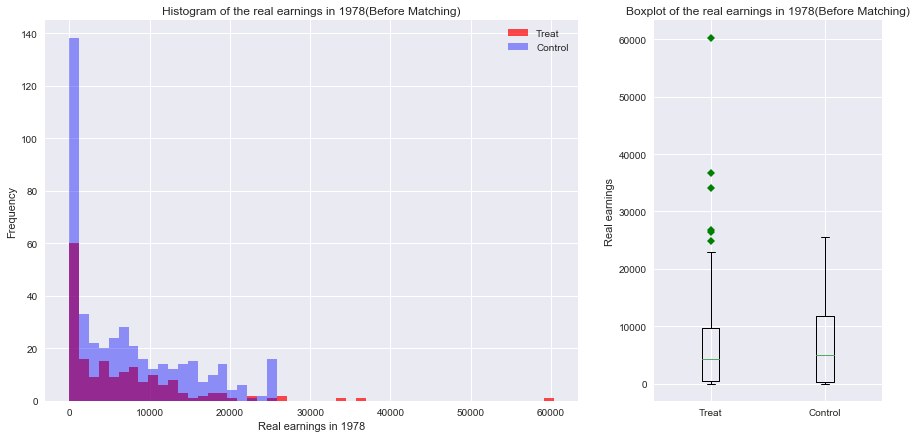

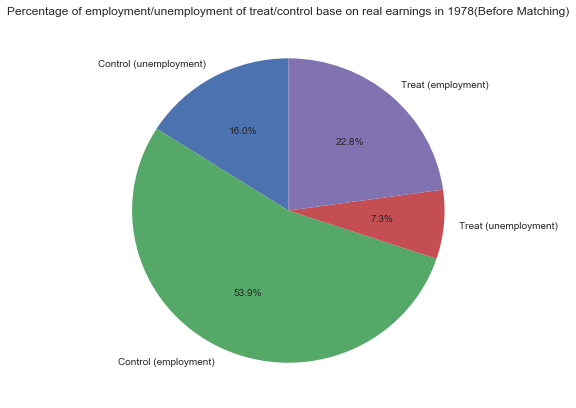

In [755]:
plot_re78(TREAT, CONTROL, '(Before Matching)')

#### Comments:

From this first naive approach, we could think that being in the treated group, this means having followed a training, did not improve the real earnings. In fact, we could even conclude that being in the treated group decreased the earnings. Indeed, we can see on the boxplots that, except for outliers, the median of the control group is higher than the one from the treated group and the same pattern applies for the 75%quantile. On the histogram, we can observe that the frequency of the two groups follow the same distribution.

But, by looking at the pie chart of unemployment in 1978, we could ask ourselves if we do not need to do a deeper analysis. So, let's try!

## 2. A closer look at the data

Try to plot a boxplot for numeric value and a pie chart for boolean value

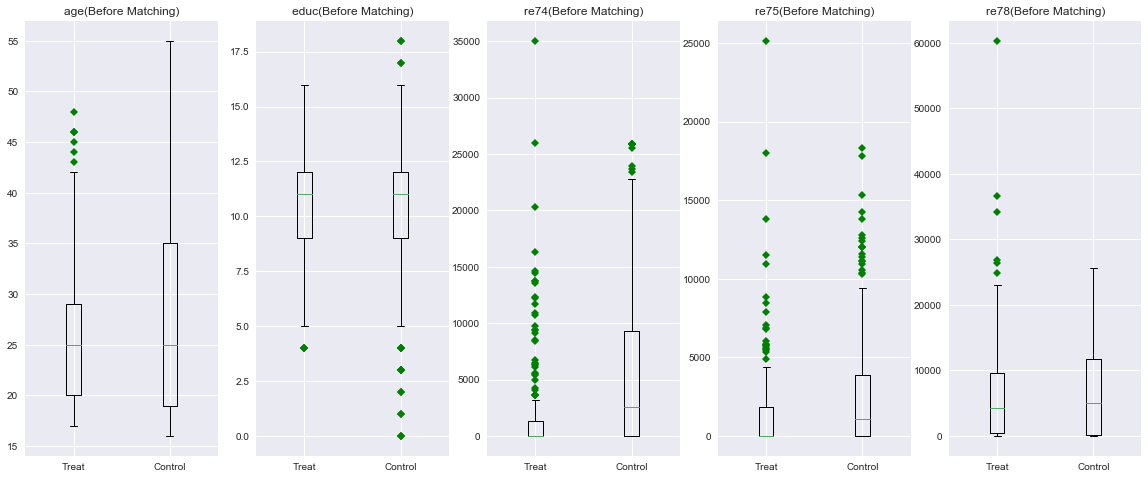

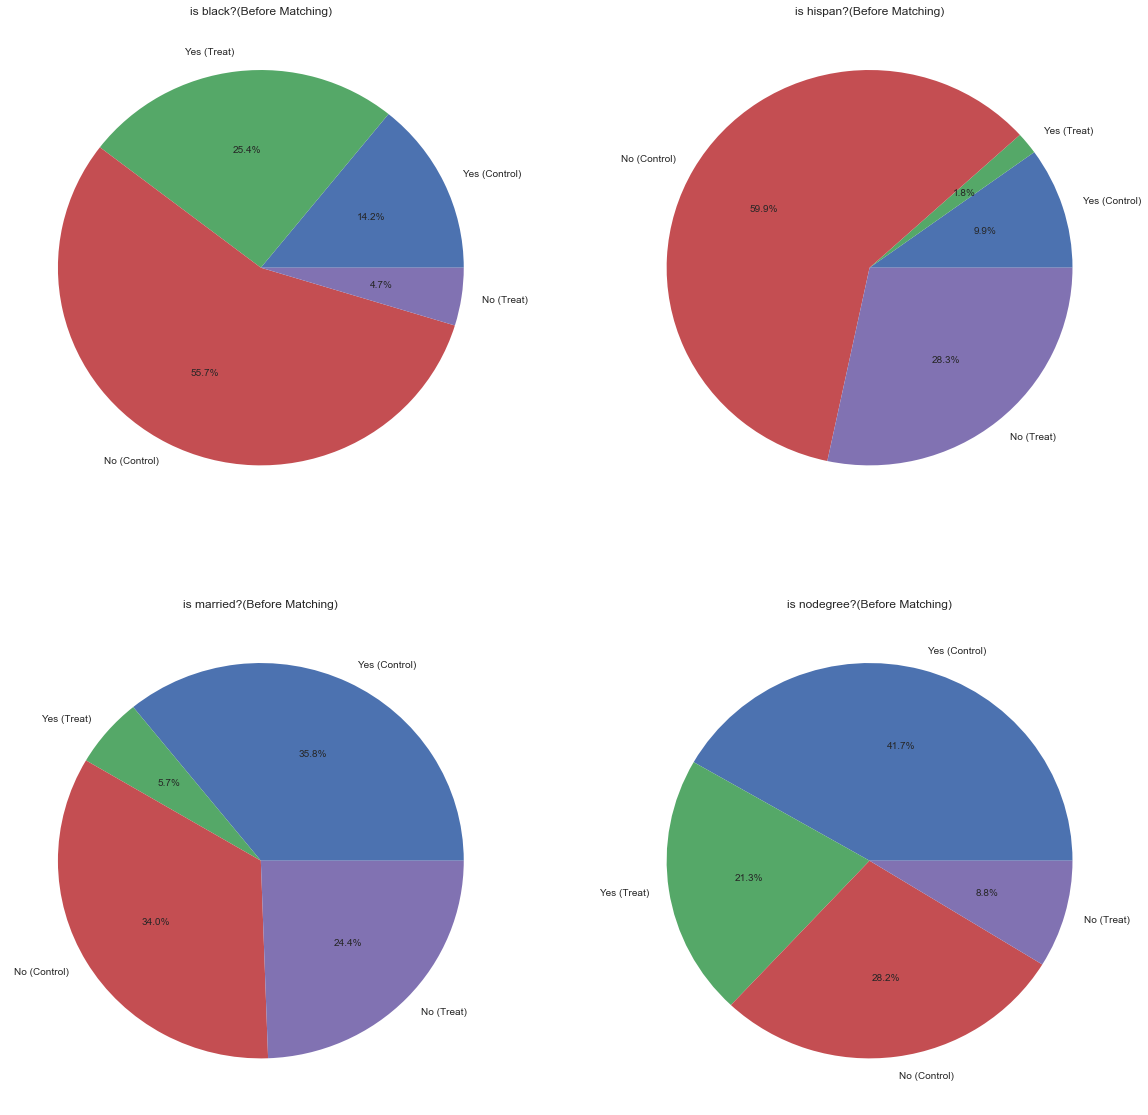

In [756]:
def plot(TREAT, CONTROL, version):
    """Boxplot for numeric value"""

    fig = plt.figure(figsize=(20,8))
    gs  = gridspec.GridSpec(1, 5, width_ratios=[1,1,1,1,1])

    numeric_cols = ['age', 'educ', 're74', 're75', 're78']

    for ind, col in enumerate(numeric_cols):
        ax = plt.subplot(gs[ind])
        ax.boxplot([TREAT[col], CONTROL[col]],0, 'gD',labels=['Treat','Control'])
        ax.set_title(col+version)


    """Pie chart for boolean value"""

    fig = plt.figure(figsize=(20,20))
    gs  = gridspec.GridSpec(2, 2)

    boolean_cols = ['black', 'hispan', 'married', 'nodegree']
    for ind, col in enumerate(boolean_cols):
        ax = plt.subplot(gs[ind])
        data = [CONTROL[CONTROL[col]==1][col].count(),
                TREAT[TREAT    [col]==1][col].count(),
                CONTROL[CONTROL[col]==0][col].count(),
                TREAT[TREAT    [col]==0][col].count()]
        ax.set_title('is '+col+'?'+version)
        labels = ['Yes (Control)' ,'Yes (Treat)', 'No (Control)', 'No (Treat)']
        ax.pie(data, labels=labels, autopct='%1.1f%%')
        
plot(TREAT, CONTROL, "(Before Matching)")

#### Comment

By looking at this deeper analysis, we understand that the composition of our two groups are not the same. Hence, we can not conclude anythng from our first naive interpretation.

Some variables are quite similar in the two groups, such as education is hispanic. On the other hand, many variables have really different distributions between the two groups, especially real earnings in 1974 and 75, is black and is married.

In order to do a proper estimation of the effect of the job training program, a matching between the two groups, treated and controls, needs to be done in order to compare them properly.

## 3. A propensity score model

Compute the propensity score by combining features. Important : DO NOT take the `re78` into account because it should be independant of the score

In [757]:
logistic = linear_model.LogisticRegression()
X = df.drop(labels=['id','treat','re78'], axis=1)
y = df['treat']
logistic.fit(X, y)
"""Propensity score is probability of receiving the treatment 
    => take the second colums of the result which is class 1 """
df['propensity'] = logistic.predict_proba(X)[:,1]
df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286


## 4. Balancing the dataset via matching

For balancing, we have to MINIMIZE the absolute propensity-score differences between the two matched subjects. Since the differences `diff` is between [0,1], the problem turns into MAXIMIZE the `2 - diff` in which we can also apply method nx.max_weight_matching.

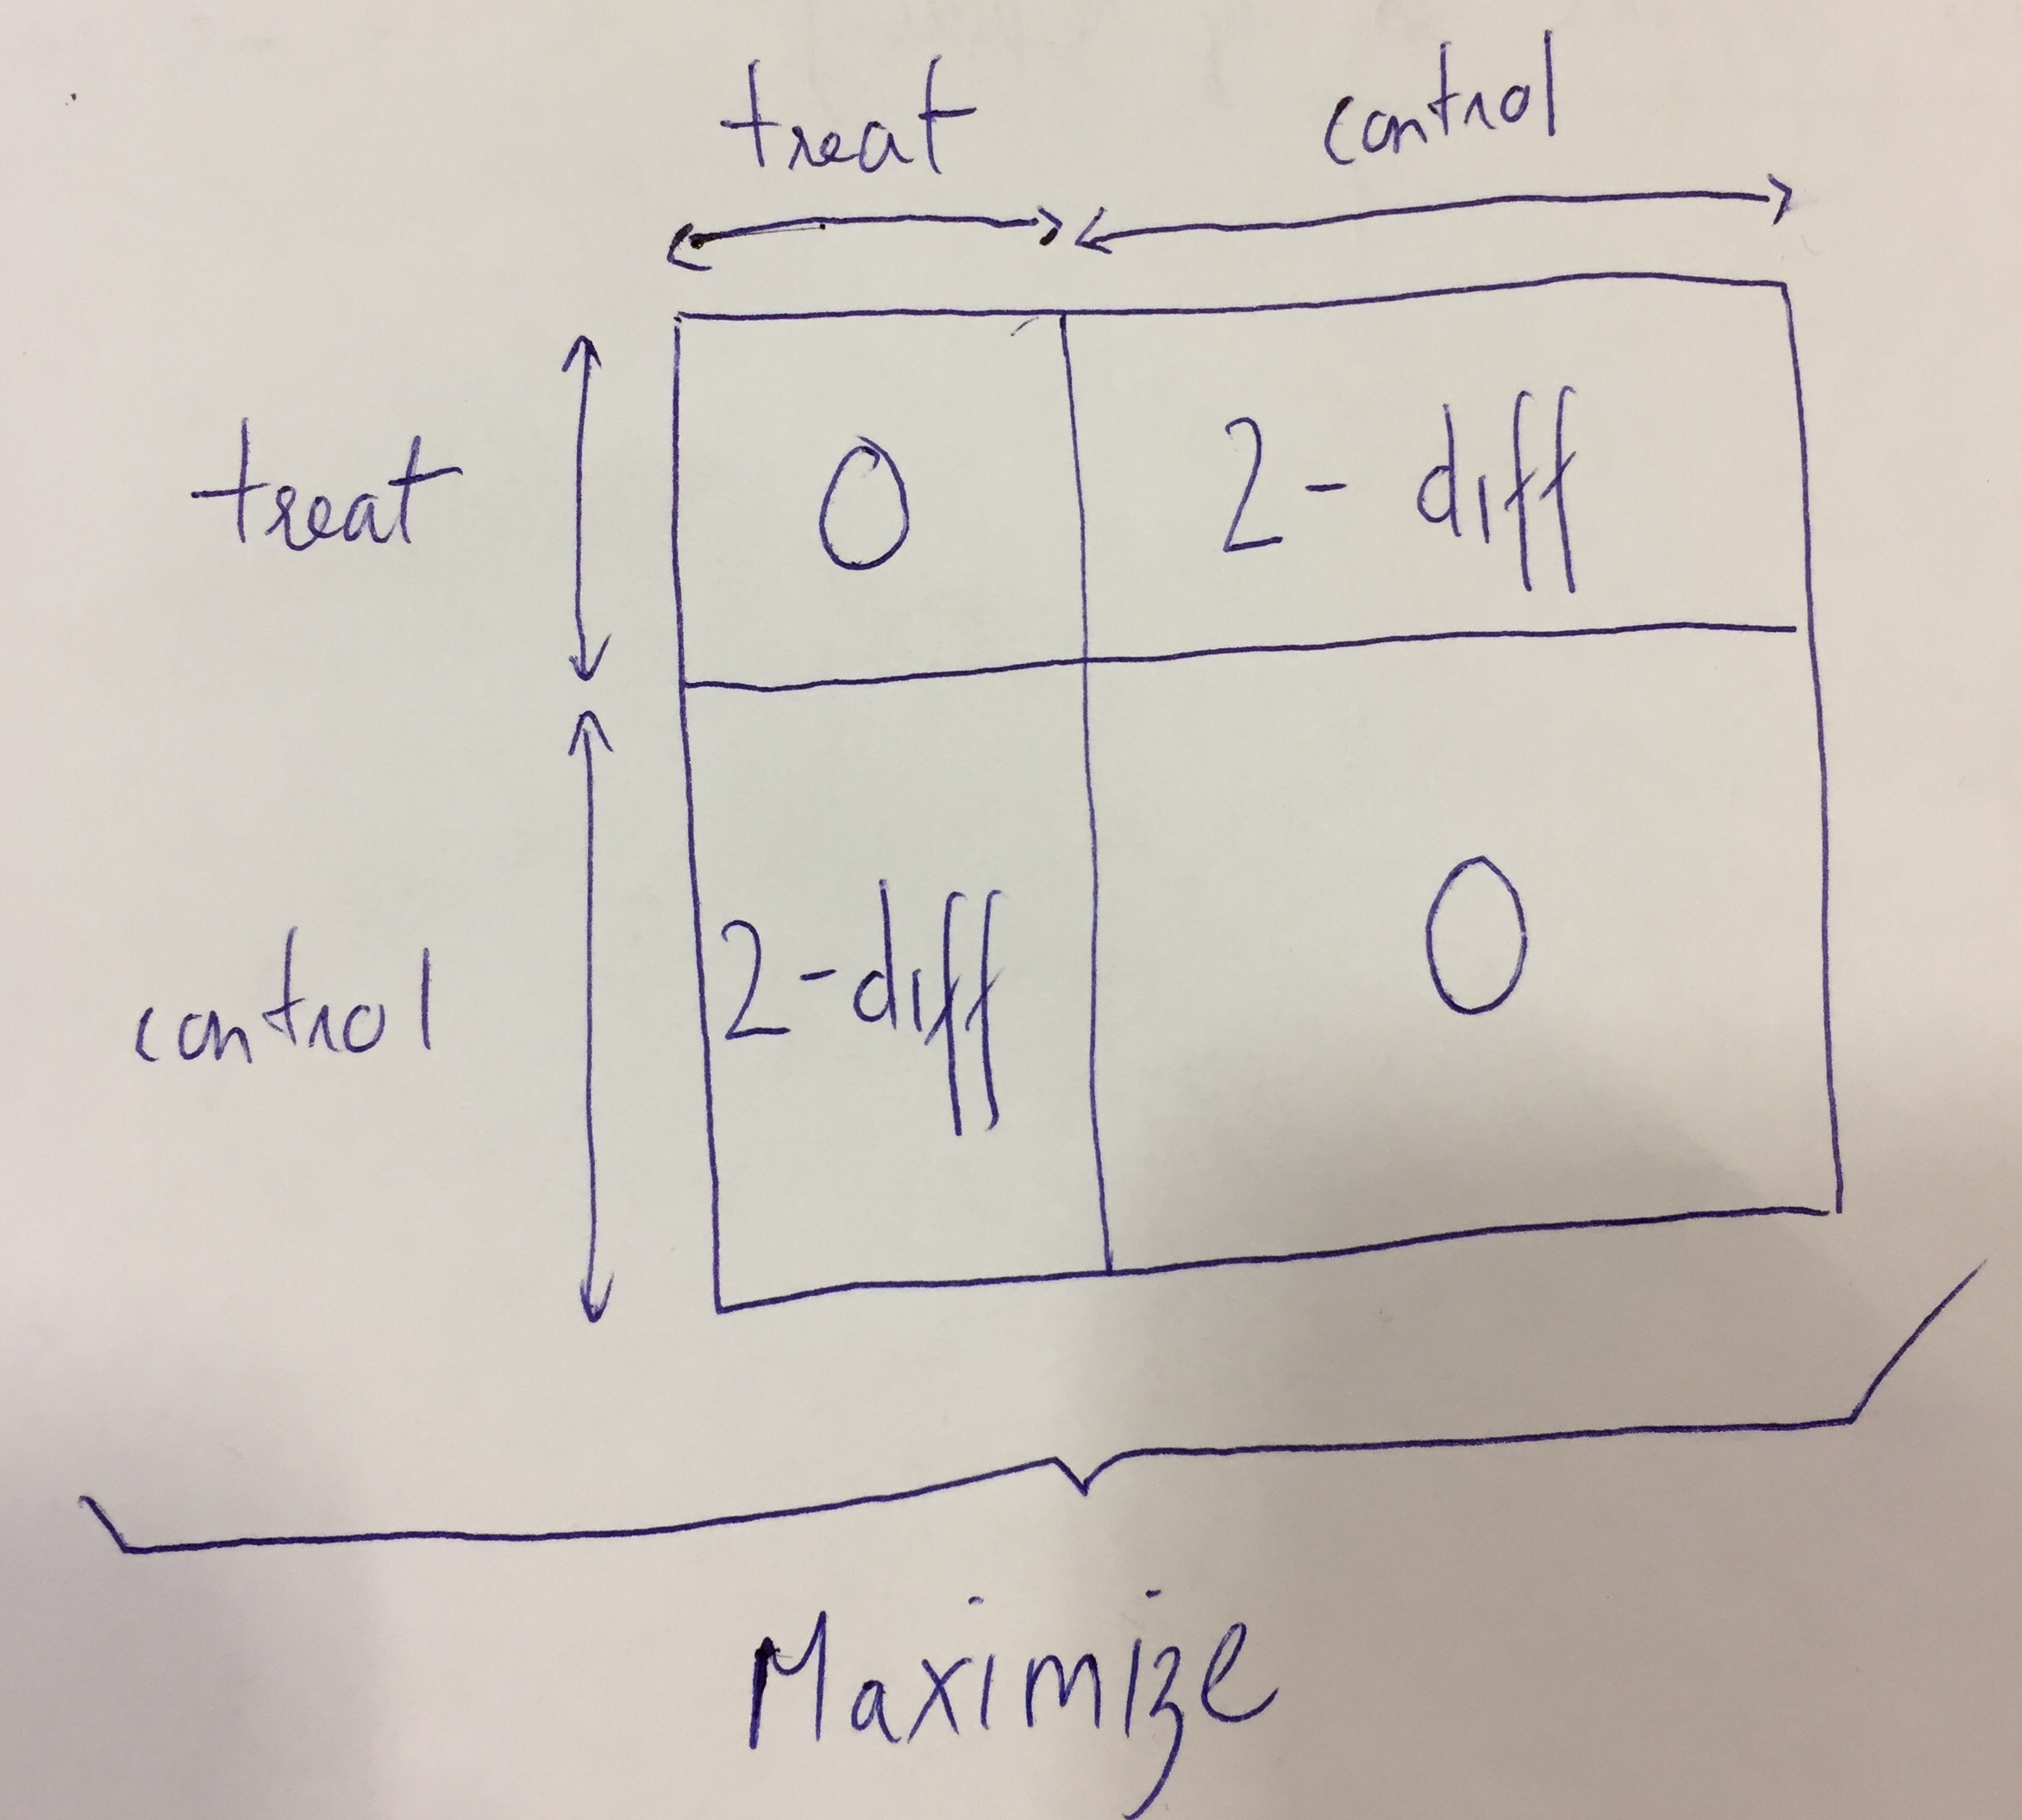

In [758]:
from IPython.display import Image
Image(filename='matrix_explication.jpg')

In [759]:
propensity_scores = np.array(df['propensity'])

"""Create an adjacency matrix"""

adj_matrix = np.zeros((len(propensity_scores), len(propensity_scores)))

treated_indexes = df.index[df['treat'] == 1].tolist()
control_indexes = df.index[df['treat'] == 0].tolist()

for i in treated_indexes:
    for j in control_indexes:
        diff =  np.abs(propensity_scores[i] - propensity_scores[j])
        similarity = 2 - diff
        adj_matrix[i, j] = similarity
        adj_matrix[j, i] = similarity


"""Create a graph and run algorithm"""
    
graph = nx.from_numpy_matrix(adj_matrix)
matching_results = nx.max_weight_matching(graph, maxcardinality=True)


"""Create a new column of matches result:
    0 means control, 1 means treat, -1 means do not find a match"""

matches = [-1]*(len(propensity_scores))
for (k, v) in matching_results.items():
    if (k in treated_indexes):
        matches[k] = 1
        matches[v] = 0
        
df['matchedQ4'] = matches
df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity,matchedQ4
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350,1
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660,1
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355,1
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151,1
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286,1


In [760]:
TREAT_Q4   = df[df['matchedQ4']==1]
CONTROL_Q4 = df[df['matchedQ4']==0]

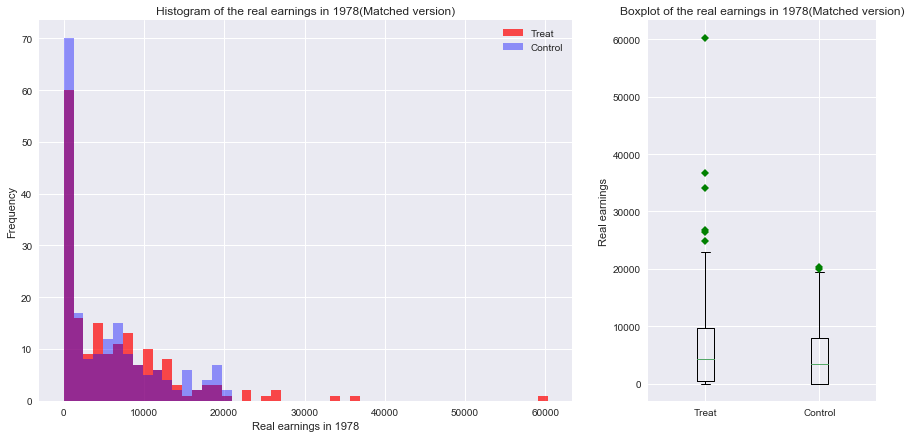

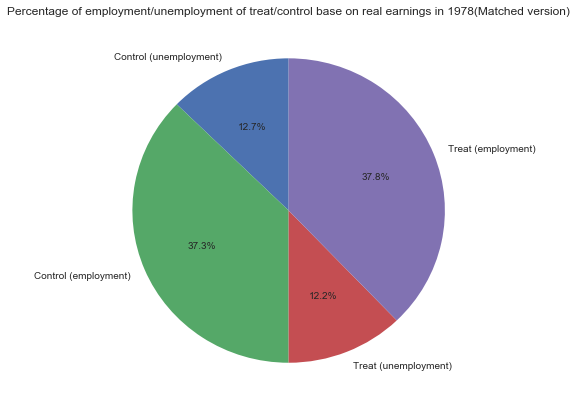

In [761]:
plot_re78(TREAT_Q4, CONTROL_Q4, '(Matched version)')

#### Comment

After having matched them, we could see that the boxplot of real earning in 1978 is really different from the one at the beginning. Moreover, the percentage of unemployment is now the same on both groups.


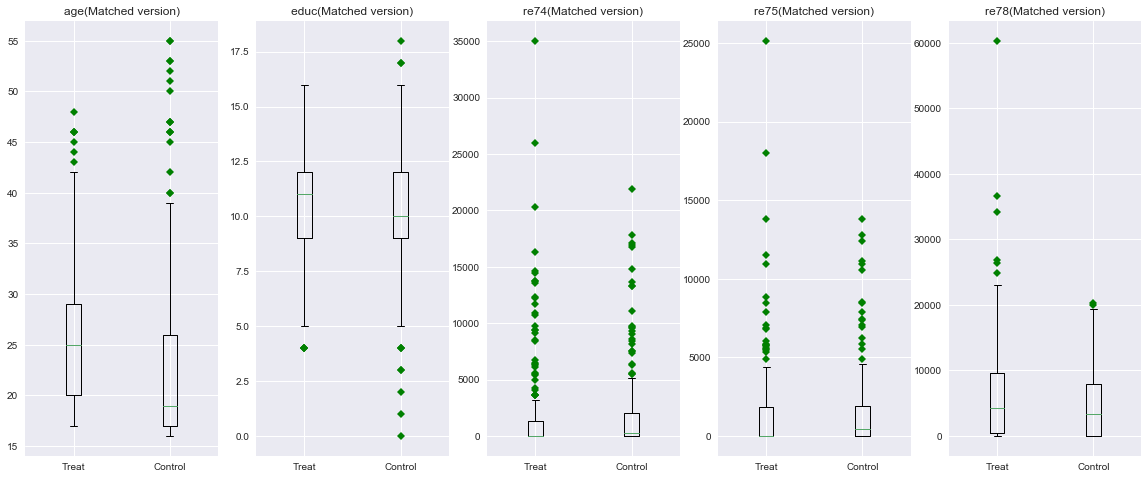

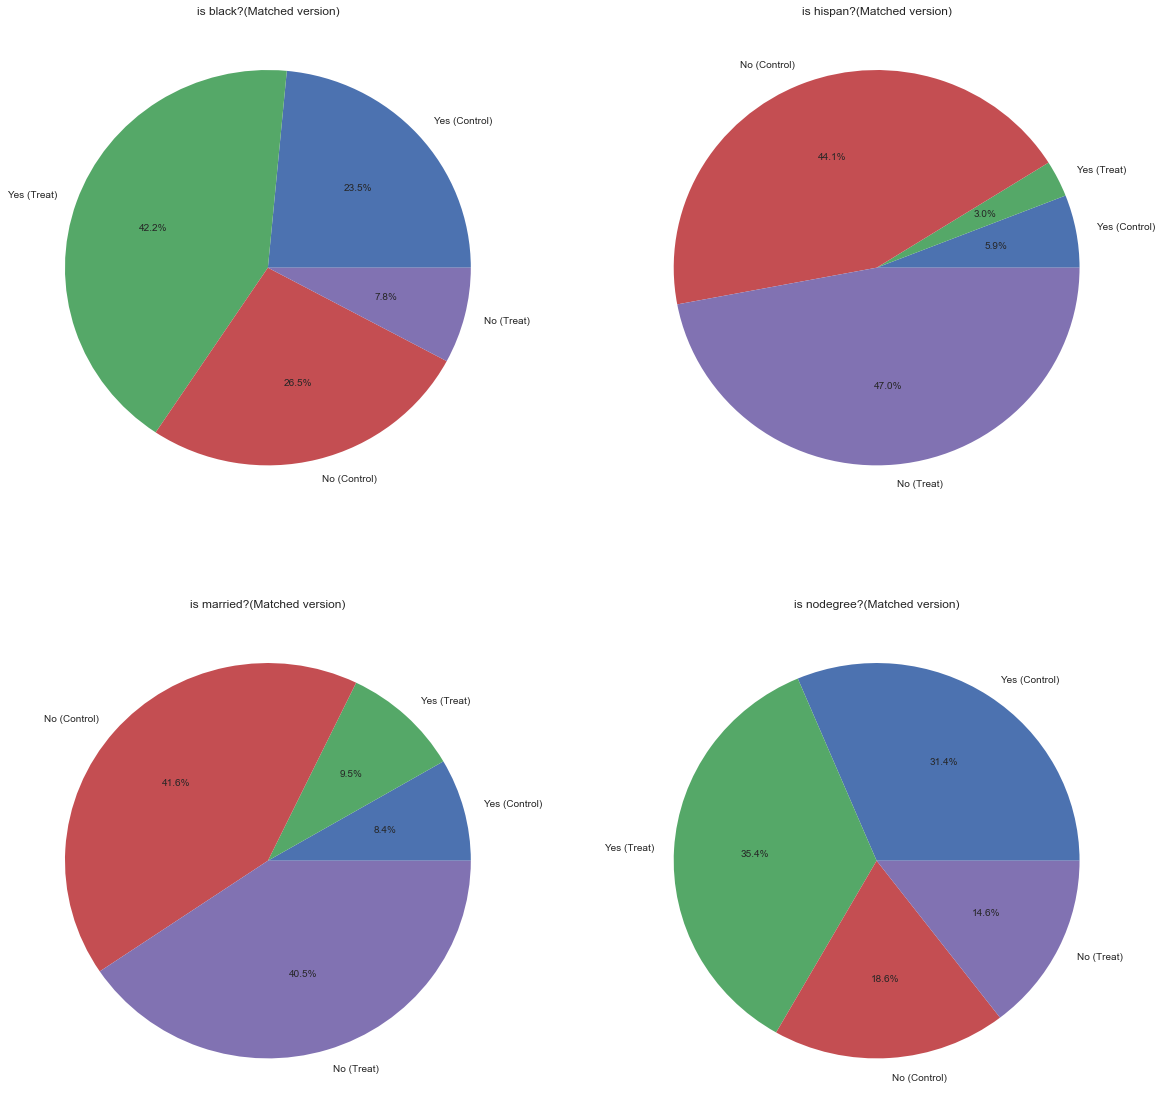

In [762]:
plot(TREAT_Q4, CONTROL_Q4, "(Matched version)")

#### Comment

- The features `married/nodegree/hispan` seem to be balanced
- However features `black/age` are not balanced after the matching

## 5. Balancing the groups further

Matching only subjects that have the same value for the problematic feature.
   For instance: we can chose a boolean feature and then split it into 2 small datasets
   and do the matching

In [763]:

def matching_further(df, by):
    
    df_0 = df[df[by]==0]
    df_1 = df[df[by]==1]   
    
    propensity_scores = np.array(df['propensity'])
    
    """Create an adjacency matrix"""
    
    adj_matrix_0 = np.zeros((len(propensity_scores), len(propensity_scores)))
    
    treated_indexes_0 = df_0.index[df_0['treat'] == 1].tolist()
    control_indexes_0 = df_0.index[df_0['treat'] == 0].tolist()
    
    for i in treated_indexes_0:
        for j in control_indexes_0:
            diff_0 =  np.abs(propensity_scores[i] - propensity_scores[j])
            similarity_0 = 2 - diff_0
            adj_matrix_0[i, j] = similarity_0
            adj_matrix_0[j, i] = similarity_0
    
    """Create a graph and run algorithm"""
    
    graph_0 = nx.from_numpy_matrix(adj_matrix_0)
    matching_results_0 = nx.max_weight_matching(graph_0, maxcardinality=True)
    
    """Do the same for df_1"""
    
    adj_matrix_1 = np.zeros((len(propensity_scores), len(propensity_scores)))
    
    treated_indexes_1 = df_1.index[df_1['treat'] == 1].tolist()
    control_indexes_1 = df_1.index[df_1['treat'] == 0].tolist()
    
    for i in treated_indexes_1:
        for j in control_indexes_1:
            diff_1 =  np.abs(propensity_scores[i] - propensity_scores[j])
            similarity_1 = 2 - diff_1
            adj_matrix_1[i, j] = similarity_1
            adj_matrix_1[j, i] = similarity_1
    
    
    """Create a graph and run algorithm"""
    
    graph_1 = nx.from_numpy_matrix(adj_matrix_1)
    matching_results_1 = nx.max_weight_matching(graph_1, maxcardinality=True)
    
    
    """Create a new column of matches result:
        0 means control, 1 means treat, -1 means do not find a match"""
    
    matches = [-1]*(len(propensity_scores))
    
    for (k, v) in matching_results_0.items():
        if (k in treated_indexes_0):
            matches[k] = 1
            matches[v] = 0
            
    for (k, v) in matching_results_1.items():
        if (k in treated_indexes_1):
            matches[k] = 1
            matches[v] = 0
    
    df['matchedBy_'+by] = matches

In [764]:
matching_further(df, 'black')
matching_further(df, 'nodegree')
matching_further(df, 'married')
df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity,matchedQ4,matchedBy_black,matchedBy_nodegree,matchedBy_married
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350,1,1,1,1
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660,1,1,1,1
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355,1,1,1,1
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151,1,1,1,1
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286,1,1,1,1


#### We match by `black`

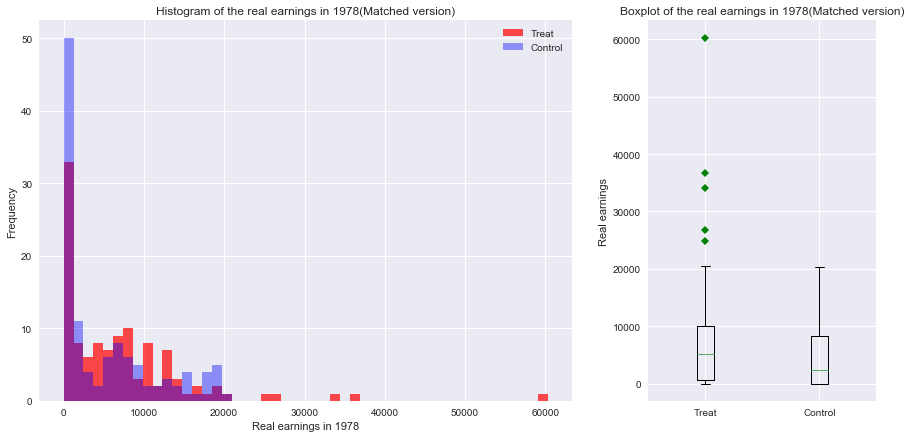

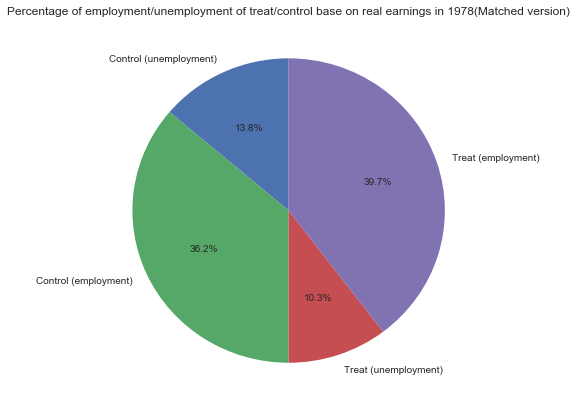

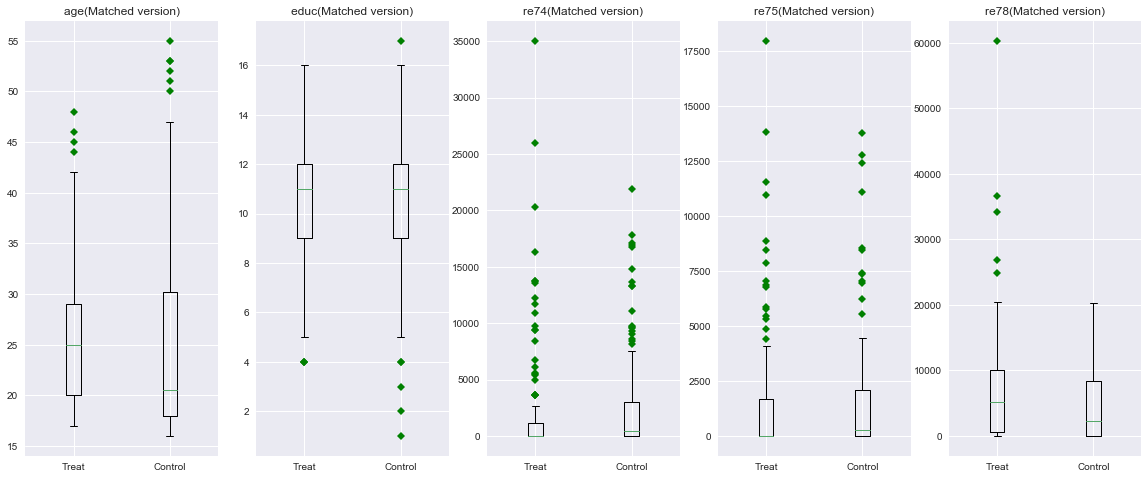

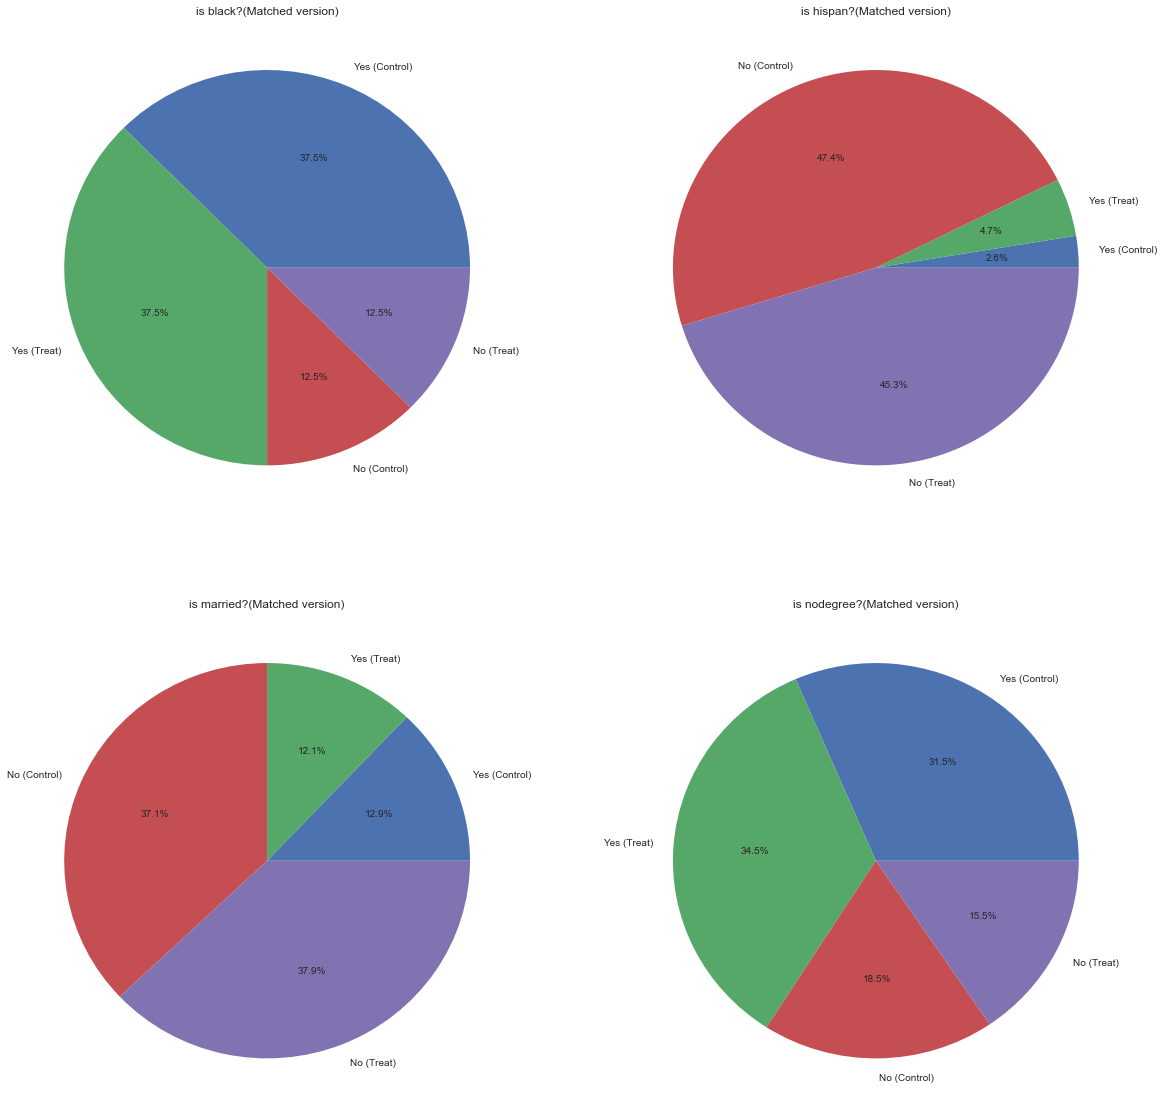

In [765]:
TREAT_Q5   = df[df['matchedBy_black']==1]
CONTROL_Q5 = df[df['matchedBy_black']==0]
plot_re78(TREAT_Q5, CONTROL_Q5, '(Matched version)')
plot(TREAT_Q5, CONTROL_Q5, "(Matched version)")

#### Comment

- With the balancing in feature `black`, now we have almost a balancing dataset for every feature.
- We saw the difference of the median of the real earnings from 1978 (after the treatment), people who participated in the program get a higher earnings.

#### Now we match by `nodegree`

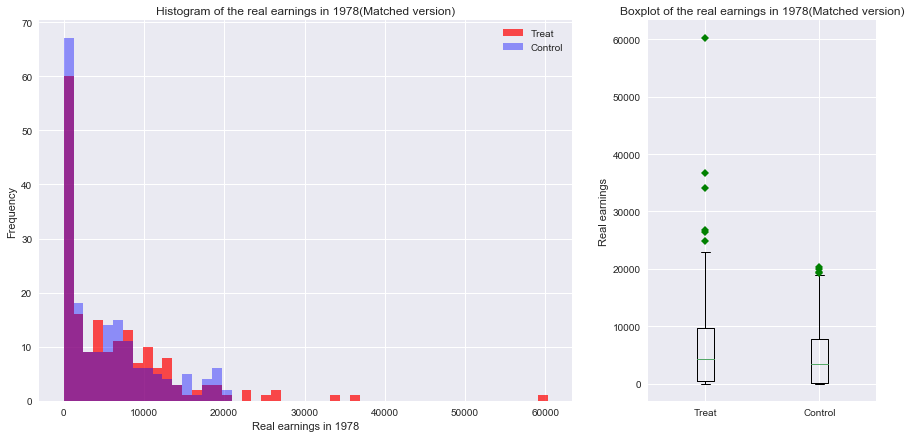

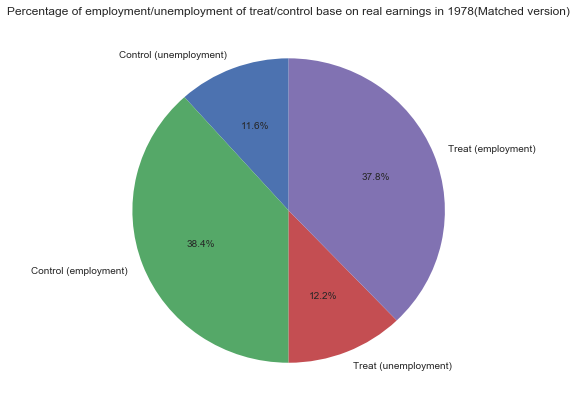

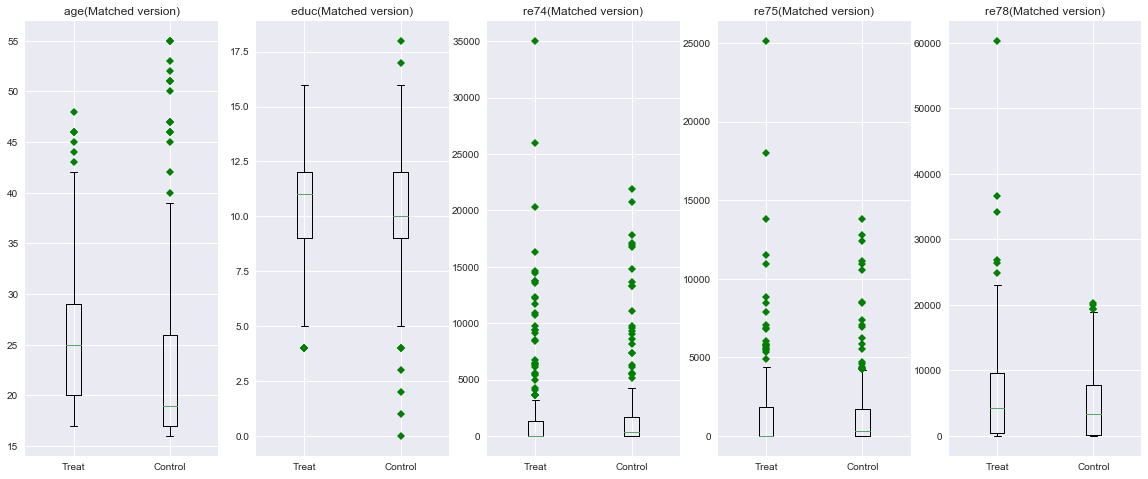

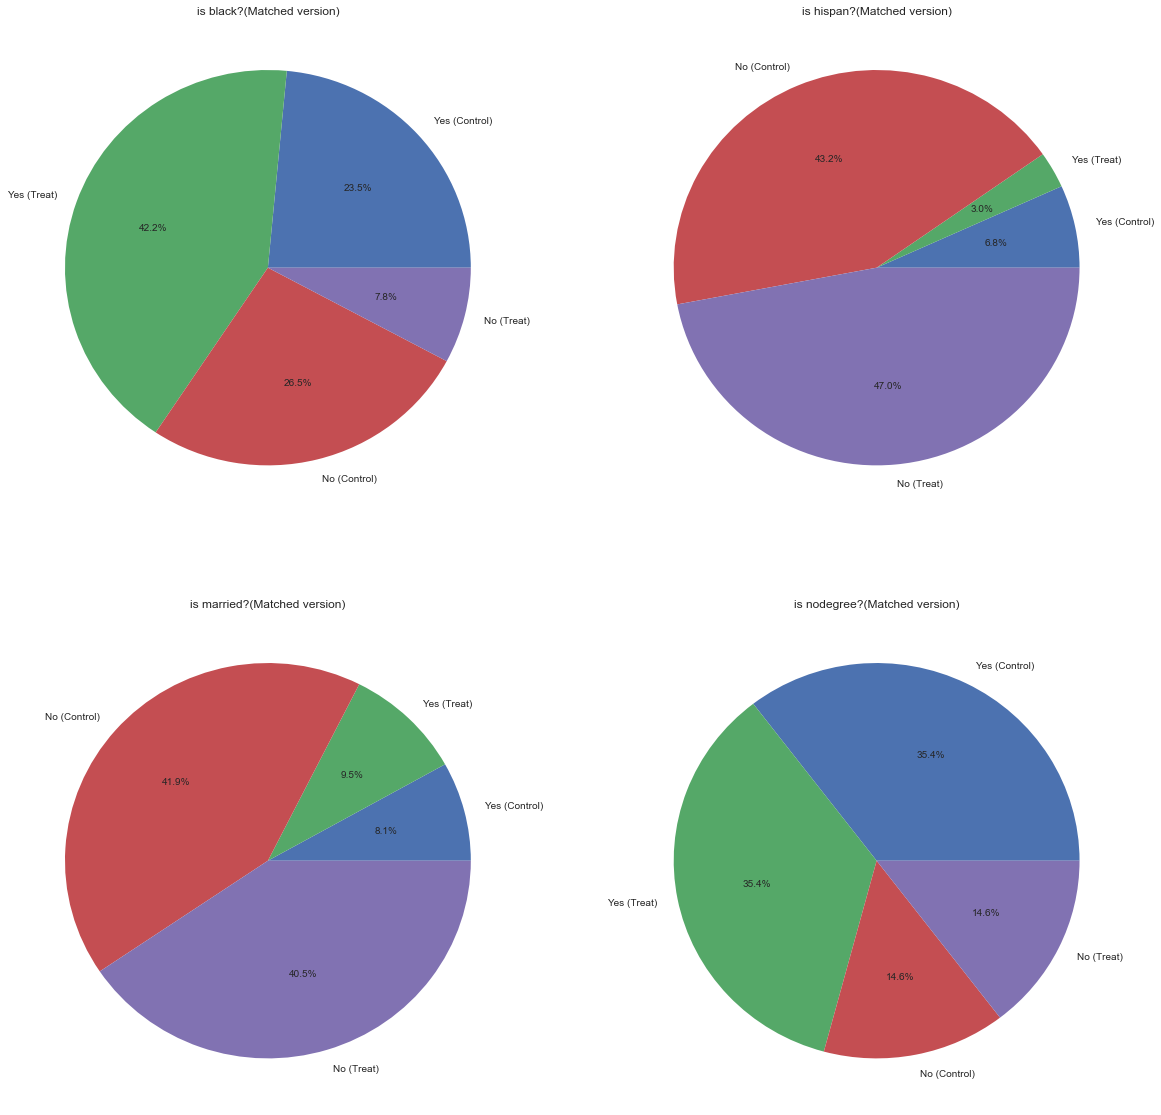

In [766]:
TREAT_Q6   = df[df['matchedBy_nodegree']==1]
CONTROL_Q6 = df[df['matchedBy_nodegree']==0]
plot_re78(TREAT_Q6, CONTROL_Q6, '(Matched version)')
plot(TREAT_Q6, CONTROL_Q6, "(Matched version)")

#### Comment

- Matching on `nodegree` didn't get us better results that the ones we got in question 4. We cannot see any improvement on the real earning in 1978

#### We match by `married`

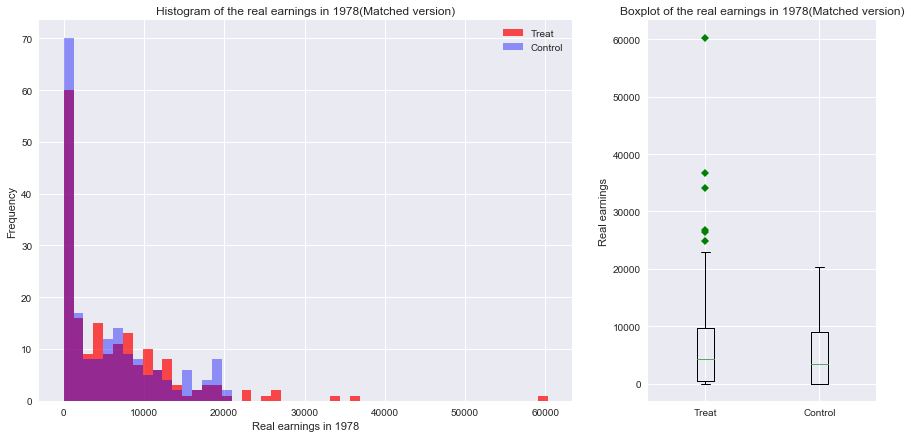

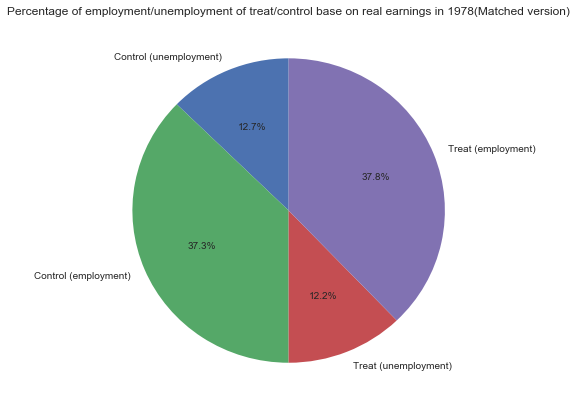

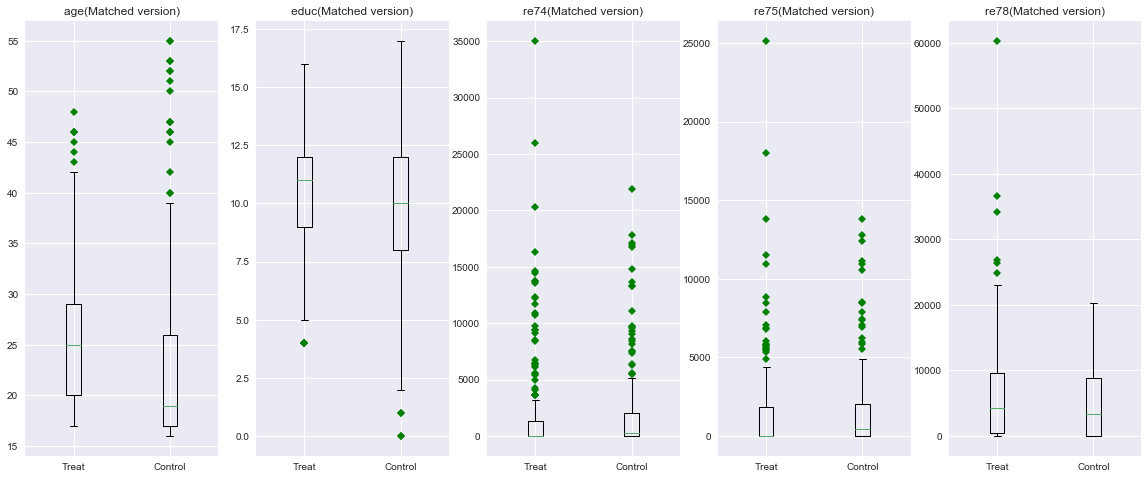

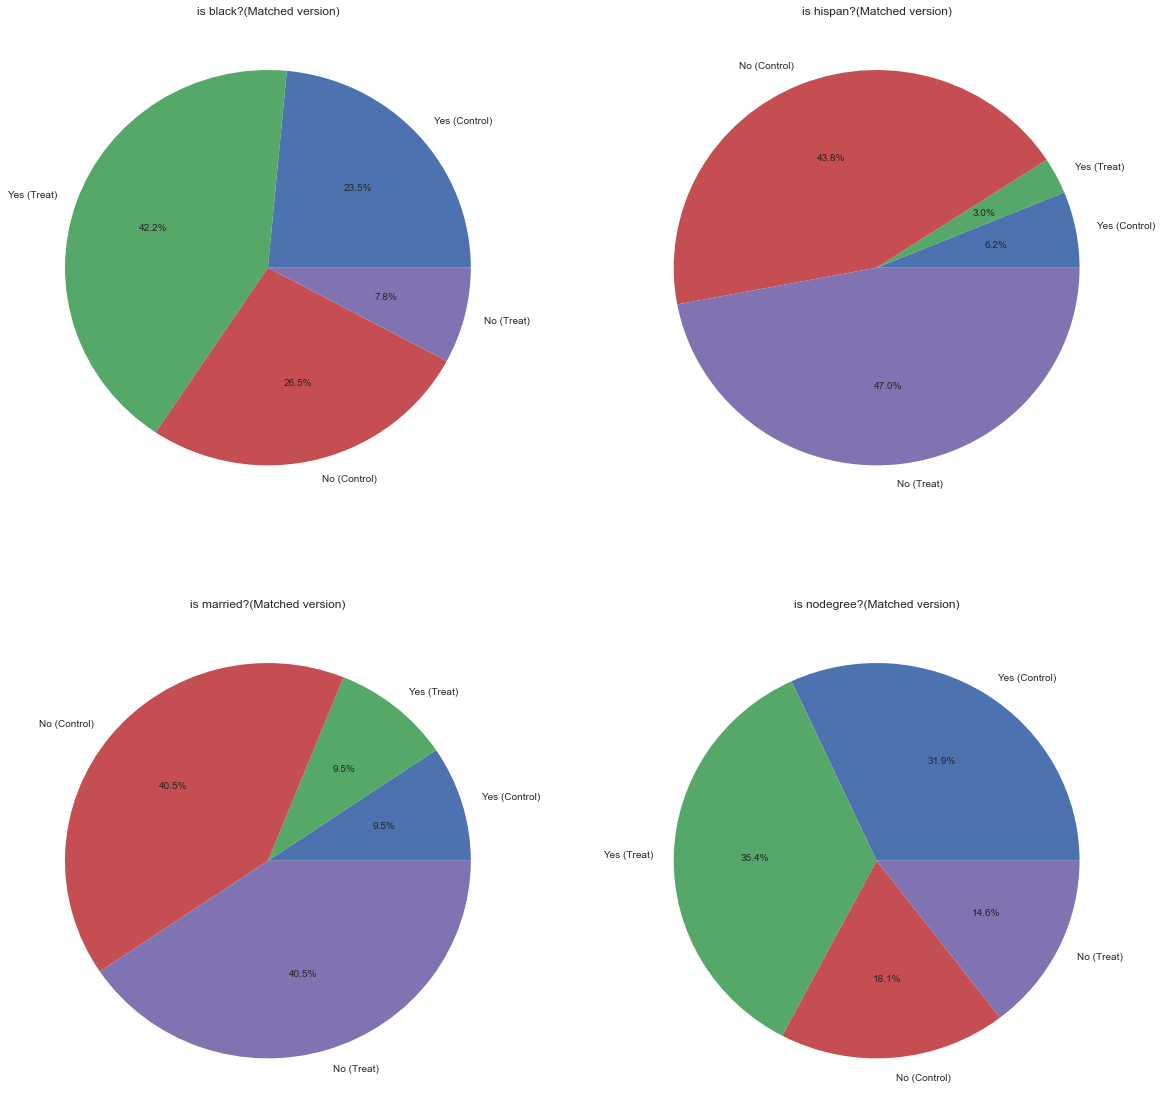

In [767]:
TREAT_Q7   = df[df['matchedBy_married']==1]
CONTROL_Q7 = df[df['matchedBy_married']==0]
plot_re78(TREAT_Q7, CONTROL_Q7, '(Matched version)')
plot(TREAT_Q7, CONTROL_Q7, "(Matched version)")

#### Commment
- Matching on `married` didn't get us better results that the ones we got in question 4. We cannot see any improvement on the real earning in 1978

## 6. A less naive analysis

So for the conclusion, let compare the histogram of real earnings in 1978 before the matching and after the matching in feature `black`

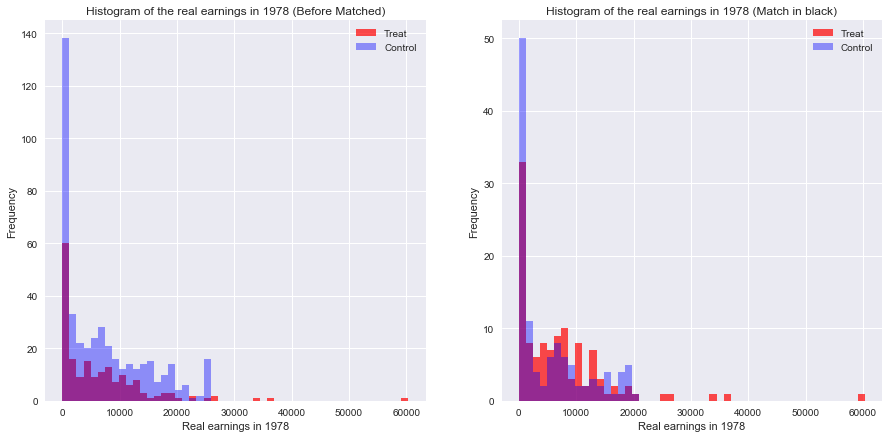

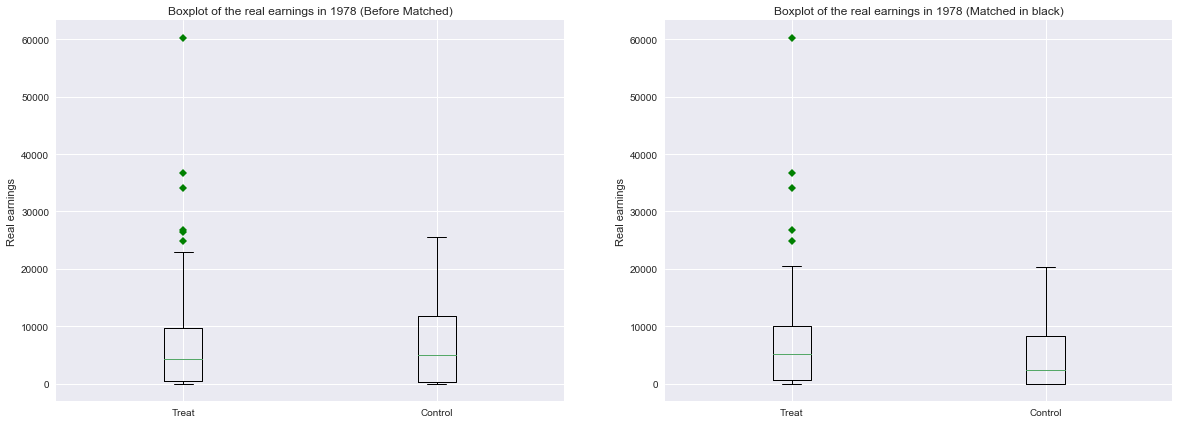

In [768]:
"""Histogram"""
fig = plt.figure(figsize=(15,7))
gs  = gridspec.GridSpec(1, 2)
bins = np.linspace(min(min(TREAT['re78']),min(CONTROL['re78'])), 
                       max(max(TREAT['re78']),max(CONTROL['re78'])), 
                       50)

ax1 = plt.subplot(gs[0])
ax1.hist(TREAT['re78']  , bins, alpha=.7, label='Treat'  ,color='r')
ax1.hist(CONTROL['re78'], bins, alpha=.4, label='Control',color='b')
ax1.set_title('Histogram of the real earnings in 1978 (Before Matched)')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Real earnings in 1978')
ax1.legend(loc='upper right')

ax2 = plt.subplot(gs[1])
ax2.hist(TREAT_Q5['re78']  , bins, alpha=.7, label='Treat'  ,color='r')
ax2.hist(CONTROL_Q5['re78'], bins, alpha=.4, label='Control',color='b')
ax2.set_title('Histogram of the real earnings in 1978 (Match in black)')
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Real earnings in 1978')
ax2.legend(loc='upper right')


"""Boxplot"""
fig = plt.figure(figsize=(20,7))
gs  = gridspec.GridSpec(1, 2)

ax1 = plt.subplot(gs[0])
ax1.boxplot([TREAT['re78'], CONTROL['re78']],0, 'gD',labels=['Treat','Control'])
ax1.set_ylabel('Real earnings')
ax1.set_title('Boxplot of the real earnings in 1978 (Before Matched)')

ax2 = plt.subplot(gs[1])
ax2.boxplot([TREAT_Q5['re78'], CONTROL_Q5['re78']],0, 'gD',labels=['Treat','Control'])
ax2.set_ylabel('Real earnings')
ax2.set_title('Boxplot of the real earnings in 1978 (Matched in black)')

#### Comment

- After the matching, now we have a balanced dataset on all features.
- We can see the difference of earnings in 1978, before versus after the match.
- We can see the difference of the median between treated group and the control group.
- It leads to the question: Does the program make treated people earn more ?

Conclusions are now the reverse: being in the treated group seems to improve the earning after some years. Indeed, the median and 75%quantile are higher in the treated group. After this closer look at the data, we would encourage this kind of job training program.

# Question 2: Applied ML

The purpose of this exercise is to build a classifier of news, assigning each news to one of the 20 categories.
We load the 20newsgroup dataset and remove the stop words, because they don't give us any information about the content of the document. Then we create the matrix of TF-IDF features, which will help us express the importance of a word to a document in a collection.

In [3]:
# load the data and create the matrix of TF-IDF features
newsgroups = fetch_20newsgroups(subset='all')
vectorizer = TfidfVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups.data)

Split the data in 3 datasets: train, test and validation. First, we split the data in 2 datasets x_train(80% of the data) and x_test_and_val(20% of the data). Then we split the second set in half: x_test(10% of the data) and x_validation(10% of the data)

In [4]:
# split the data set into train, test and validation
x_train ,x_test_and_val, y_train, y_test_and_val = train_test_split(vectors,newsgroups.target,test_size=0.2, train_size=0.8)
x_test, x_validation, y_test, y_validation = train_test_split(x_test_and_val,y_test_and_val,test_size=0.5, train_size=0.5)

We create a random forest classifier with the default parameters. Fit it with the x_train dataset and we calculate the score for the predictions of the test data.

In [5]:
# calculate the score without tuning the parameters 
forest = RandomForestClassifier()
forest.fit(x_train,y_train)
print("Score with default parameters:",forest.score(x_test,y_test))

Score with default parameters: 0.738461538462


In [14]:
hyperparameter_grid = {
    'n_estimators': np.arange(0, 500, 10),
    'max_depth': np.arange(0, 60, 3)
}
grid_forest = GridSearchCV(forest, param_grid=hyperparameter_grid,n_jobs=-1)
grid_forest.fit(x_validation, y_validation)
grid_forest.score(x_test, y_test)
grid_forest.best_params_

{'max_depth': 55, 'n_estimators': 480}

In [7]:
nb_estimators, max_depth = grid_forest.best_params_

We use the grid_search function to tune the parameters and then create the classifier with those parameters. We fit the classifier using the train dataset and calculate the score of the predictions for the test dataset. As we can see the score has improved, which is expected because we adapted the values of the parameters(nb_estimators and max_depth) to our dataset.

In [15]:
# create a random forest classifier with the fine-tune parameters train it and calculate the score for the test dataset
grid_forest = RandomForestClassifier(n_estimators= nb_estimators, max_depth=max_depth)
grid_forest.fit(x_train,y_train)

print("Score with tuned hyper-parameters(nb_estimators=, max_depth=):",grid_forest.score(x_test,y_test))

Score with tuned hyper-parameters(nb_estimators=, max_depth=): 0.850397877984


We create the confusion matrix in order to evaluate the quality of the output of a classifier on the news dataset. We normalize the matrix so that it will be easier to visualize the result.

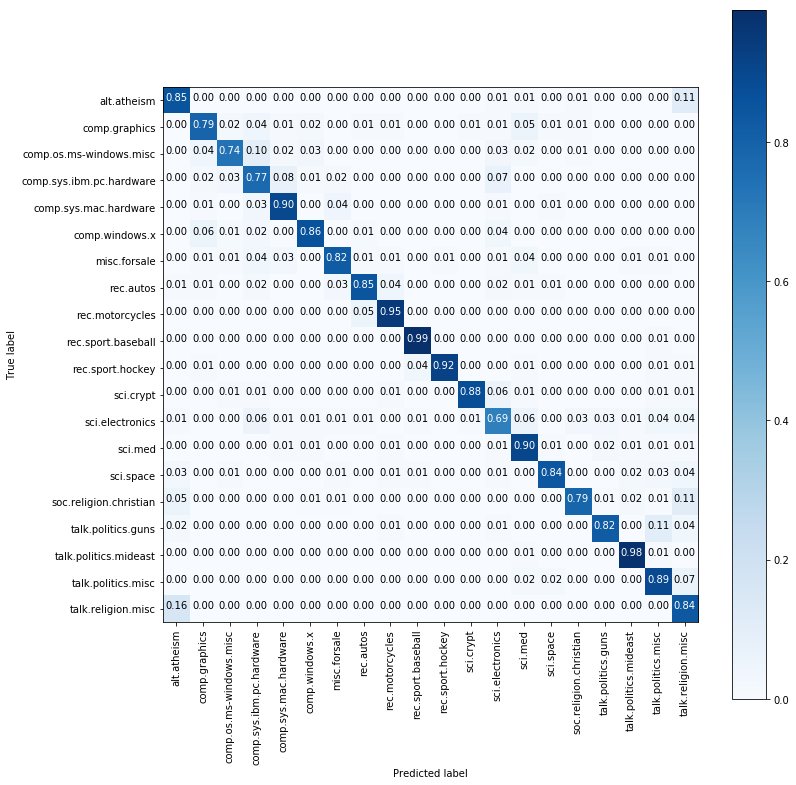

In [16]:
# create, normalize and plot the confusion matrix
conf_matrix=confusion_matrix(grid_forest.predict(x_test),y_test)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10,10))
cmap = plt.cm.Blues
plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
plt.colorbar()
tick_marks = np.arange(len(newsgroups.target_names))
plt.tight_layout()
tick_marks = np.arange(len(newsgroups.target_names))
plt.xticks(tick_marks, newsgroups.target_names, rotation=90)
plt.yticks(tick_marks, newsgroups.target_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
fmt = '.2f' 
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")
plt.show()

In [17]:
# get the feature importance and sort it in decreasing order
importances = grid_forest.feature_importances_
indices = np.argsort(importances)
indices = indices[::-1]

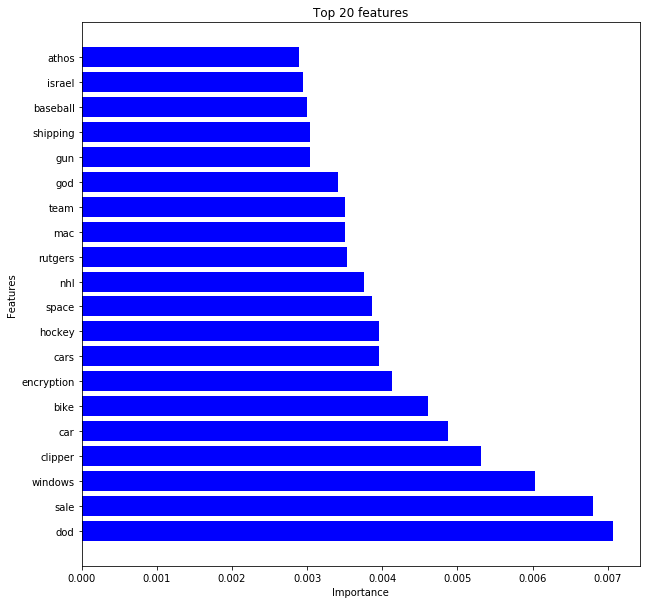

In [18]:
#plot the 20 most important features
plt.figure(figsize=(10,10))
features = newsgroups.target_names
plt.barh(range(len(indices[:20])), importances[indices[:20]], color='b', align='center')
plt.yticks(range(len(indices[:20])), np.array(vectorizer.get_feature_names())[indices[:20]])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 20 features')
plt.show()

As we can see most of the important features are keywords of the news categories. For example baseball in rec.sport.baseball, encryption in sic.encrypt and so on. The most important feature is dod(United States Department of Defense). This is reasonable becase it is an acronym that we usually use in politics and it is barely used in the other categories like com.graphict, alt.atletism and so on.